## ExMAS
> Equilibrium matching


In [1]:
import os
import math
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
cwd = os.getcwd()
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import display
pd.options.display.max_columns = None

In [3]:
os.chdir(os.path.join(cwd,'../../..'))
import ExMAS.main
import ExMAS.utils
from ExMAS.utils import inData as inData
from ExMAS.main import matching
from ExMAS.extras import games, pricings, prunings, pipeline

In [6]:
params = ExMAS.utils.get_config('ExMAS/spinoffs/game/pipe.json') # load the default 
params.t0 = pd.to_datetime(params.t0)
params.matching_obj = 'u_pax'
inData = ExMAS.utils.load_G(inData, params, stats=True)  # download the graph
params.nP = 100
params.simTime = 0.1
params.shared_discount = 0.3
inData = ExMAS.utils.generate_demand(inData, params)  # generate requests

In [7]:
inData = ExMAS.main(inData, params, plot = False)
KPIs = inData.sblts.res.to_frame('u_pax')
inData = games.prepare_PoA(inData)  # prepare data structures

08-04-21 09:48:20-WARNING-Prepare for game:  1/6
08-04-21 09:48:21-WARNING-Prepare for game:  2/6
08-04-21 09:48:21-WARNING-Prepare for game:  3/6
08-04-21 09:48:22-WARNING-Prepare for game:  4/6
08-04-21 09:48:49-WARNING-Prepare for game:  5/6
08-04-21 09:48:51-WARNING-Prepare for game:  6/6


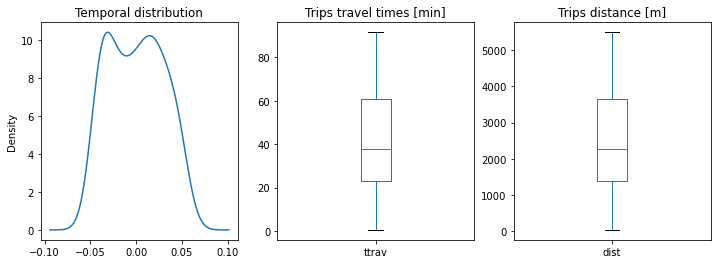

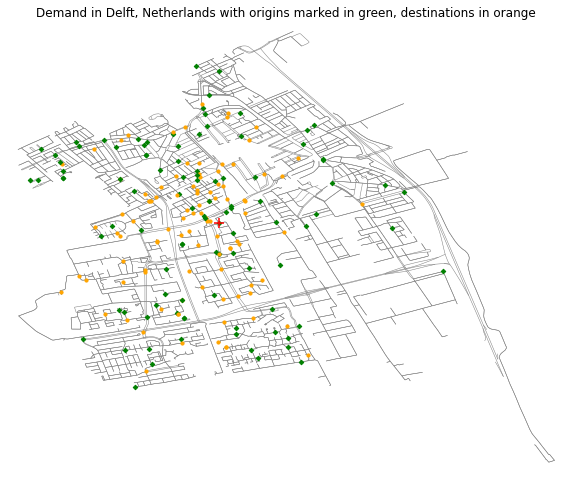

In [8]:
ExMAS.utils.plot_demand(inData, params)

### incidence matrix
rows are trips columns are rides,
1 if trip blongs to a ride, 0 otherwise

light - feasible | blue - pruned | dark - selected


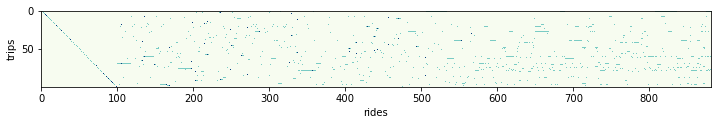

In [9]:
def plot_im(inData):
    mtx = np.vstack(inData.sblts.rides['row'].values).T  # creates a numpy array for the constrains
    m = pd.DataFrame(mtx).astype(int)
    plt.rcParams['figure.figsize'] = [12, int(12*inData.sblts.rides.shape[0]/inData.requests.shape[0])]
    m.index.name = 'trips'
    m.columns.name = 'rides'
    inData.sblts.m = m
    m_solution = m.copy()
    fig, ax = plt.subplots()

    for col in m.columns:
        if inData.sblts.rides.loc[col].selected==0:
            if inData.sblts.rides.loc[col].pruned == True:
                m_solution[col] = 0.5*m[col]
            else:
                m_solution[col] = 0.2*m[col]
        else:
            m_solution[col] = m[col]

    from matplotlib import colors
    cmap = 'GnBu'
    ax.imshow(m_solution, cmap=cmap, interpolation = 'Nearest')
    ax.set_ylabel('trips')
    _ = ax.set_xlabel('rides')
    print('light - feasible | blue - pruned | dark - selected')
    return m_solution
m_solution = plot_im(inData)

### pricing

eq. 1 , eq.2

In [11]:

params.time_cost = params.VoT # travellers' cost per travel time
params.wait_cost = params.time_cost*1.5 # and waiting
params.sharing_penalty_fixed = 0 # fixed penalty (EUR) per 
params.sharing_penalty_multiplier = 0 # fixed penalty (EUR) per 

params.veh_cost = 1.3*params.VoT/params.avg_speed # operating costs per kilometer
params.fixed_ride_cost = 0.5 # ride fixed costs (per vehicle)

In [13]:
inData = games.prepare_PoA(inData)

08-04-21 09:56:55-WARNING-Prepare for game:  1/6
08-04-21 09:56:56-WARNING-Prepare for game:  2/6
08-04-21 09:56:57-WARNING-Prepare for game:  3/6
08-04-21 09:56:57-WARNING-Prepare for game:  4/6
08-04-21 09:57:30-WARNING-Prepare for game:  5/6
08-04-21 09:57:31-WARNING-Prepare for game:  6/6


In [18]:
def update_costs(inData, params):
    '''
    Set a costs attributes for the rides
    :param inData: there are two tables, one is inData.sblts.rides taken directly from ExMAS,
    another it rides_multi_index, where data about each ride-traveller information is stored.
    It is generated in the games.PreparePoA
    :param params:
    :return:
    '''

    rm = inData.sblts.rides_multi_index  # ride (group) - traveller data
    rides = inData.sblts.rides  # rides data

    rm['distance'] = rm.ride_time * params.avg_speed  # update distances from travel times

    rm['cost_veh'] = params.veh_cost * rm['distance'] + params.fixed_ride_cost  # vehicle running costs

    # formula for the user costs (disutility)
    rm['cost_user'] = params.time_cost * rm.ttrav_sh + \
                      params.wait_cost * abs(rm.delay) + \
                      params.sharing_penalty_fixed * rm.shared + \
                      params.sharing_penalty_multiplier * params.time_cost * rm.shared * rm.ttrav_sh

    rides['costs_user'] = rm.groupby('ride').sum()['cost_user']  # sum user costs for a ride
    rides['costs_veh'] = rm.groupby('ride').max()['cost_veh']  # assign vehicle costs for rides
    rides['costs_total'] = rides['costs_user'] + rides['costs_veh']  # total ride costs (vehicle + all users)

    rm['total_group_cost'] = rm.apply(lambda r: rm.loc[r.ride, :].cost_user.sum() + rm.loc[r.ride, :].cost_veh.max(),
                                      axis=1)  # assign  total ride costs in rm table
    rides['total_group_cost'] = rides['costs_total']  # seems repetition of costs total
    rides['cost_efficiency'] = rides['total_group_cost'] / rides.degree  # total cost per rider

    rm['cost_efficiency'] = rm['total_group_cost'] / rm.degree

    # cost of a single ride for a user
    rm['cost_single'] = rm.apply(
        lambda r: rm[(rm.traveller == r.traveller) & (rm.shared == False)]['total_group_cost'].max(), axis=1)

    rm['total_singles'] = rm.apply(lambda r: rm.loc[r.ride, :].cost_single.sum(), axis=1)  # costs of single rides per
    # group
    rides['total_singles'] = rm.groupby('ride').sum()['cost_single']  # total single ride costs per ride
    rides['residual'] = rides['costs_total'] - rides['total_singles']  # residual, for some pricing algos
    rm['residual_user'] = rm.apply(lambda r: rides.loc[r.ride].residual, axis=1)

    inData.sblts.rides_multi_index = rm  # store back results
    inData.sblts.rides = rides

    return inData
inData = update_costs(inData, params)
inData.sblts.rides_multi_index.tail(9)

ride  traveller  shared  degree  treq ride_time  dist  ttrav  \
878 78   878         78    True       4   307      1231  4825    603   
879 1    879          1    True       4     6      1043  5496    687   
    49   879         49    True       4   192      1043  3958    494   
    78   879         78    True       4   307      1043  4825    603   
    76   879         76    True       4   295      1043  1182    147   
880 1    880          1    True       4     6       935  5496    687   
    49   880         49    True       4   192       935  3958    494   
    60   880         60    True       4   236       935  3033    379   
    77   880         77    True       4   299       935  1361    170   

        ttrav_sh  delay distance cost_veh  cost_user  total_group_cost  \
878 78       765   85.5     9848  6.10105   3.126375          19.35730   
879 1        873   31.0     8344  5.24565   3.218250          16.91115   
    49       734  -16.0     8344  5.24565   2.653000          16.91115   
    78       798  -25.0     8344  5.24565   2.924250          16.91115   
    76       715   70.0     8344  5.24565   2.870000          16.91115   
880 1        935   31.0     7480  4.75425   3.435250          15.71625   
    49       622  -16.0     7480  4.75425   2.261000          15.71625   
    60       713   23.0     7480  4.75425   2.616250          15.71625   
    77       505  168.0     7480  4.75425   2.649500          15.71625   

        cost_single  total_singles  residual_user  cost_efficiency  
878 78      5.35415       18.90500        0.45230         4.839325  
879 1       6.03035       17.54455       -0.63340         4.227788  
    49      4.47670       17.54455       -0.63340         4.227788  
    78      5.35415       17.54455       -0.63340         4.227788  
    76      1.68335       17.54455       -0.63340         4.227788  
880 1       6.03035       15.92650       -0.21025         3.929062  
    49      4.47670       15.92650       -0.21025         3.929062  
    60      3.55095       15.92650       -0.21025         3.929062  
    77      1.86850       15.92650       -0.21025         3.929062

### uniform split

In [38]:
inData = pricings.uniform_split(inData) 
rs = inData.sblts.rides.sample(4).index
inData.sblts.rides_multi_index.loc[rs,:]

ride  traveller  shared  degree  treq ride_time  dist  ttrav  \
29  29    29         29   False       1   215       168  1344    168   
40  40    40         40   False       1   286       376  3009    376   
145 45   145         45    True       2   312       844  4581    572   
    32   145         32    True       2   233       844  2411    301   
175 1    175          1    True       3     0       652  2005    250   
    8    175          8    True       3    71       652  2699    337   
    11   175         11    True       3    77       652  2361    295   

        ttrav_sh  delay distance cost_veh  cost_user  total_group_cost  \
29  29       168    0.0     1344   1.2644   0.588000          1.852400   
40  40       376    0.0     3008   2.2108   1.316000          3.526800   
145 45       829  -42.5     6752   4.3402   3.124625         10.594700   
    32       808   57.5     6752   4.3402   3.129875         10.594700   
175 1        333  -10.5     5216   3.4666   1.220625          9.133975   
    8        545   25.5     5216   3.4666   2.041375          9.133975   
    11       319  245.5     5216   3.4666   2.405375          9.133975   

        cost_single  total_singles  residual_user   UNIFORM  
29  29      1.85240        1.85240       0.000000  1.852400  
40  40      3.52680        3.52680       0.000000  3.526800  
145 45      5.10460        8.02765       2.567050  5.297350  
    32      2.92305        8.02765       2.567050  5.297350  
175 1       2.51250        8.60010       0.533875  3.044658  
    8       3.21285        8.60010       0.533875  3.044658  
    11      2.87475        8.60010       0.533875  3.044658

In [39]:
inData.sblts.rides.loc[rs][['costs_veh','costs_user']].sort_index()

,costs_veh,costs_user
29,1.2644,0.588000
40,2.2108,1.316000
145,4.3402,6.254500
175,3.4666,5.667375


In [40]:
inData.sblts.res['costs_veh'] = inData.sblts.rides[inData.sblts.rides.selected==1]['costs_veh'].sum()
inData.sblts.res['costs_user'] = inData.sblts.rides[inData.sblts.rides.selected==1][ 'costs_user'].sum()
inData.sblts.res.to_frame(name='EXMAS').loc[['VehHourTrav','PassHourTrav','shared_ratio','costs_veh', 'costs_user']].T

,VehHourTrav,PassHourTrav,shared_ratio,costs_veh,costs_user
EXMAS,14010,18332,0.88,79.247,77.595


# Algorithms

In [19]:
PRICINGS = dict()  # pricings to apply and their names
PRICINGS['UNIFORM'] = pricings.uniform_split
PRICINGS['EXTERNALITY'] = pricings.externality_split
PRICINGS['RESIDUAL'] = pricings.residual_split
PRICINGS['SUBGROUP'] = pricings.subgroup_split
for PRICING, pricing in PRICINGS.items():
    inData = pricing(inData)  # apply pricing strategy

In [14]:
inData.results.rides = inData.sblts.rides.copy()  # copy tables to collect results
inData.results.rm = inData.sblts.rides_multi_index.copy()
inData.results.KPIs = dict()

### TNE 
$c_i({i})>=c_i(G)$

only rides for which all users have lower costs than single (similar to ExMAS)

params.multi_platform_matching = True
params.assign_ride_platforms = False
inData = prunings.algo_TNE(inData, price_column='UNIFORM')  # apply pruning strategies for a given pricing strategy
inData = pipeline.single_eval(inData, params,
                     MATCHING_OBJS = ['UNIFORM'],  # this can be more
                     PRUNINGS = ['TNE'],  # and this can be more
                     PRICING = 'UNIFORM',  # this is taken from first level loop
                     minmax = ['min'], store_res = False)  # direction BPoA, WPoA
plot_im(inData)
inData.sblts.res['costs_veh'] = inData.sblts.rides[inData.sblts.rides.selected==1]['costs_veh'].sum()
inData.sblts.res['costs_user'] = inData.sblts.rides[inData.sblts.rides.selected==1][ 'costs_user'].sum()
inData.sblts.res.to_frame(name='TNE').loc[['VehHourTrav','PassHourTrav','shared_ratio','costs_veh', 'costs_user']].T

### HERMETIC 


only Hermetic groups are left in the search space

Subgroup H of Group G is not hermetic if somoeone wants to leave H for G

16-12-20 11:35:12-WARNING-Prunings:  ['HERMETIC']
16-12-20 11:35:12-WARNING-Pruned nRides 58/202
16-12-20 11:35:12-WARNING-Mutually exclusives 0
16-12-20 11:35:12-WARNING-UNIFORM-['UNIFORM']-['HERMETIC']-UNIFORM-min
light - feasible | blue - pruned | dark - selected


,VehHourTrav,PassHourTrav,shared_ratio,costs_veh,costs_user
Hermetic,15048,16314,0.2,91.3097,58.7773


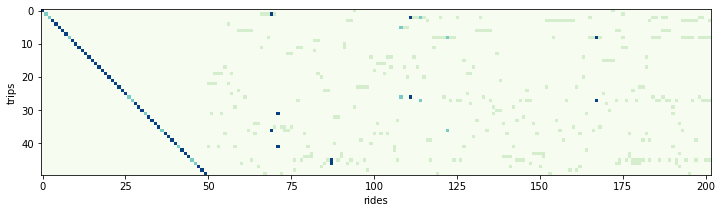

In [51]:
inData = prunings.algo_HERMETIC(inData, price_column='UNIFORM')  # apply pruning strategies for a given pricing strategy
inData = pipeline.single_eval(inData, params,
                     MATCHING_OBJS = ['UNIFORM'],  # this can be more
                     PRUNINGS = ['HERMETIC'],  # and this can be more
                     PRICING = 'UNIFORM',  # this is taken from first level loop
                     minmax = ['min'], store_res = False)  # direction BPoA, WPoAplot_im(inData)
plot_im(inData)
inData.sblts.res['costs_veh'] = inData.sblts.rides[inData.sblts.rides.selected==1]['costs_veh'].sum()
inData.sblts.res['costs_user'] = inData.sblts.rides[inData.sblts.rides.selected==1][ 'costs_user'].sum()
inData.sblts.res.to_frame(name='Hermetic').loc[['VehHourTrav','PassHourTrav','shared_ratio','costs_veh', 'costs_user']].T

### RUE 

two megreable groups cannot be together in the solution (if everyone is better-off in $G_1 \cup G_2$ when group $G_1$ and $G_2$ are merged)

16-12-20 11:35:44-WARNING-Prunings:  ['RUE']
16-12-20 11:35:44-WARNING-Pruned nRides 202/202
16-12-20 11:35:44-WARNING-Mutually exclusives 22
16-12-20 11:35:44-WARNING-UNIFORM-['UNIFORM']-['RUE']-UNIFORM-min
light - feasible | blue - pruned | dark - selected


,VehHourTrav,PassHourTrav,shared_ratio,costs_veh,costs_user
TNE,13943,16726,0.44,83.6914,64.9495


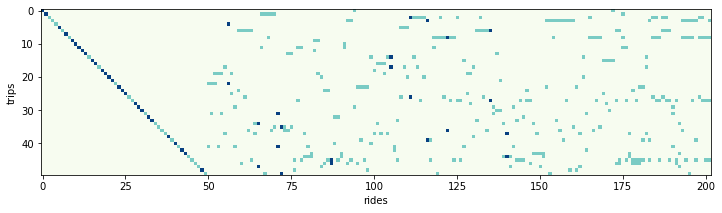

In [52]:
inData = prunings.algo_RUE(inData, price_column='UNIFORM')  # apply pruning strategies for a given pricing strategy
inData = pipeline.single_eval(inData, params,
                     MATCHING_OBJS = ['UNIFORM'],  # this can be more
                     PRUNINGS = ['RUE'],  # and this can be more
                     PRICING = 'UNIFORM',  # this is taken from first level loop
                     minmax = ['min'], store_res = False)  # direction BPoA, WPoAplot_im(inData)

plot_im(inData)
inData.sblts.res['costs_veh'] = inData.sblts.rides[inData.sblts.rides.selected==1]['costs_veh'].sum()
inData.sblts.res['costs_user'] = inData.sblts.rides[inData.sblts.rides.selected==1][ 'costs_user'].sum()
inData.sblts.res.to_frame(name='TNE').loc[['VehHourTrav','PassHourTrav','shared_ratio','costs_veh', 'costs_user']].T

### RSIE 

two *unstable* groups cannot be together in the solution 

if anyone from $G1$ wants to join $G2$ and it is better for the moving traveller and group accepting him.

In [16]:
inData = prunings.algo_RSIE(inData, price_column='UNIFORM')  # apply pruning strategies for a given pricing strategy
inData = pipeline.single_eval(inData, params,
                     MATCHING_OBJS = ['total_group_cost'],  # this can be more
                     PRUNINGS = ['RUE'],  # and this can be more
                     PRICING = 'EXTERNALITY',  # this is taken from first level loop
                     minmax = ['min'], store_res = False)  # direction BPoA, WPoAplot_im(inData)
plot_im(inData)

inData.sblts.res['costs_veh'] = inData.sblts.rides[inData.sblts.rides.selected==1]['costs_veh'].sum()
inData.sblts.res['costs_user'] = inData.sblts.rides[inData.sblts.rides.selected==1][ 'costs_user'].sum()
inData.sblts.res.to_frame(name='TNE').loc[['VehHourTrav','PassHourTrav','shared_ratio','costs_veh', 'costs_user']].T

08-04-21 11:17:07-WARNING-Searching unstable pairs 0/881. 0 found so far


KeyError: "['UNIFORM'] not in index"

### TSE 

strongest notion, explored heuristically

best groups are selected, based on their cost per user.

11-12-20 09:47:29-WARNING-Pruned nRides 264/264
light - feasible | blue - pruned | dark - selected


,VehHourTrav,PassHourTrav,shared_ratio,costs_veh,costs_user
TNE,16282,20586,0.3,95.4926,69.1819


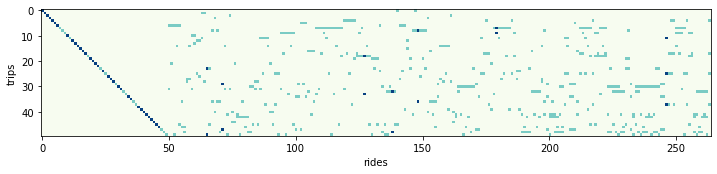

In [19]:
inData = pipeline.single_eval(inData, params, prunings.algo_TSE, PRICING = 'uniform_split', ALGO = 'TSE', objs = ['u_veh'],minmax = ['min'], store_res = False)
plot_im(inData)
inData.sblts.res['costs_veh'] = inData.sblts.rides[inData.sblts.rides.selected==1]['costs_veh'].sum()
inData.sblts.res['costs_user'] = inData.sblts.rides[inData.sblts.rides.selected==1][ 'costs_user'].sum()
inData.sblts.res.to_frame(name='TNE').loc[['VehHourTrav','PassHourTrav','shared_ratio','costs_veh', 'costs_user']].T

# Grafs

In [ ]:
import netwulf as nw
G = ExMAS.utils.make_shareability_graph(inData.sblts.requests, inData.sblts.rides)
nw.visualize(G)


---
# Bigger experiment

* 300 travellers
* uniform pricing
* 5 algorithms + window based
* matching_objs: 
    * user + veh
    * veh
* directions:
    * min (Best Price of Anarchy)
    * max (Worst Price of Anarchy)

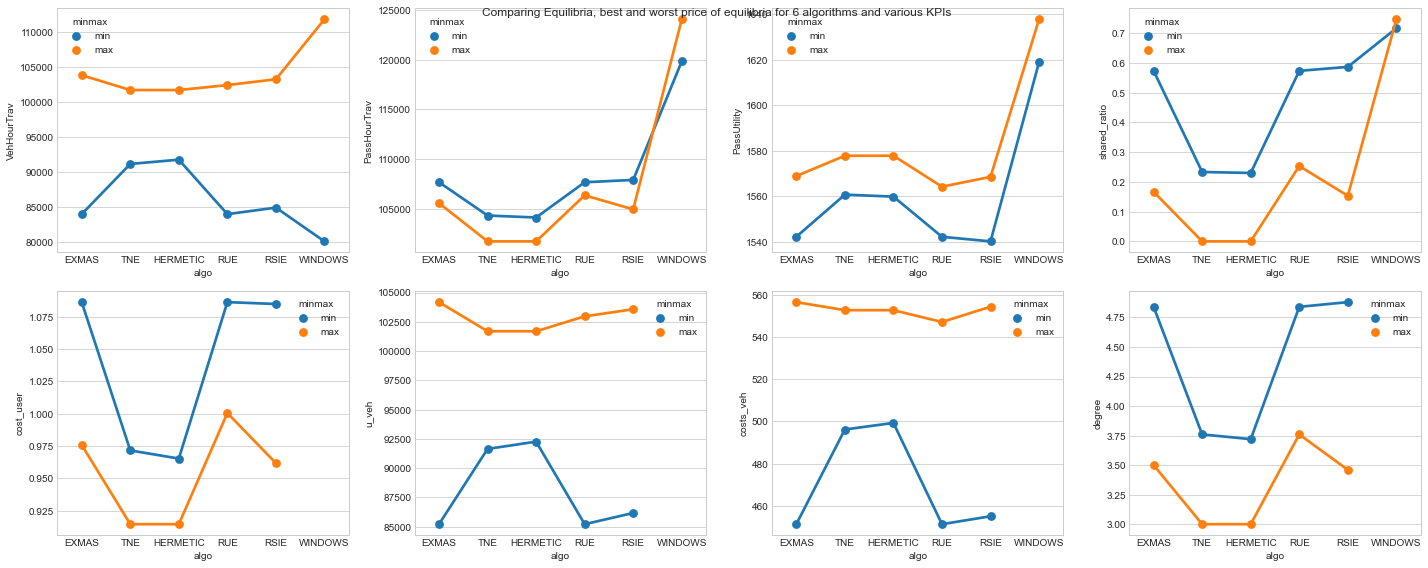

In [20]:
def plot_KPIs(obj = 'costs_veh'):
    plt.style.use('seaborn-whitegrid')
    KPIs = pd.read_csv('ExMAS/extras/PIPE_KPIs.csv', index_col = 0)
    KPIs = KPIs[~(KPIs.algo == 'TSE')]
    KPIs.obj = KPIs.obj.apply(lambda x: 'costs_user' if x == 'u_pax' else x)
    KPIs.obj = KPIs.obj.apply(lambda x: 'costs_veh' if x == 'u_veh' else x)
    to_plot = KPIs[(KPIs.obj == obj)]
    fig, axes = plt.subplots(2,4,figsize = (20,8))
    axes = axes.flatten()
    sns.pointplot(y='VehHourTrav',x = 'algo', data = to_plot, ax = axes[0], hue = 'minmax')
    
    sns.pointplot(y='PassHourTrav',x = 'algo', data = to_plot, ax = axes[1], hue = 'minmax')
    sns.pointplot(y='PassUtility',x = 'algo', data = to_plot, ax = axes[2], hue = 'minmax')
    sns.pointplot(y='shared_ratio',x = 'algo', data = to_plot, ax = axes[3], hue = 'minmax')
    sns.pointplot(y='cost_user',x = 'algo', data = to_plot, ax = axes[4], hue = 'minmax')
    sns.pointplot(y='u_veh',x = 'algo', data = to_plot, ax = axes[5], hue = 'minmax')
    sns.pointplot(y='costs_veh',x = 'algo', data = to_plot, ax = axes[6], hue = 'minmax')
    sns.pointplot(y='degree',x = 'algo', data = to_plot, ax = axes[7], hue = 'minmax')
    fig.suptitle('Comparing Equilibria, best and worst price of equilibria for 6 algorithms and various KPIs')
    plt.tight_layout()
    

plot_KPIs()

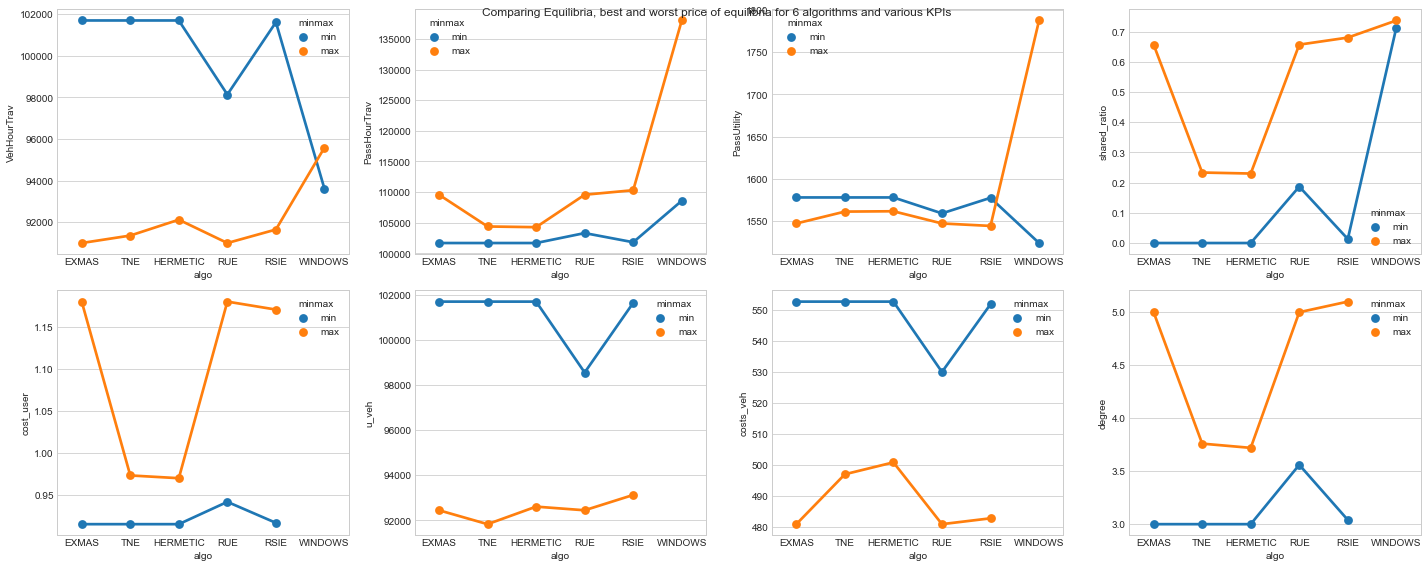

In [21]:
plot_KPIs('costs_user')

---
(c) Rafał Kucharski, Delft, 2020